<center><h1><b>NYC Apartment Search</b></h1></center>

---
# Setup

## Python Project Library Imports

### Overview
This code cell organizes a wide range of imports for a Python project, covering standard operations, data handling, database interactions, and GIS functionalities.

### Categories
- **Standard Library**: Basic utilities like `os`, `json`, `pathlib`, and date-time handling.
- **Data Manipulation & Visualization**: Libraries such as `pandas`, `matplotlib`, and `requests` for data processing and plotting.
- **Database & GIS**: Tools like `psycopg2`, `geoalchemy2`, and `geopandas` for database operations and geospatial data.
- **SQLAlchemy**: ORM functionalities, including model creation and geospatial data handling in databases.


In [2]:
# Standard library imports
import os                      # For interacting with the operating system
import json                    # For parsing and generating JSON
import unittest                # For unit testing
import pathlib                 # For object-oriented filesystem paths
import urllib.parse            # For parsing URLs
from datetime import datetime  # For handling dates and times
from pathlib import Path       # For object-oriented file system path handling
from typing import List        # For type hinting lists

# Data manipulation and visualization
import matplotlib.pyplot as plt        # For creating static, animated, and interactive visualizations
import matplotlib.dates as mdates      # For handling date formatting in matplotlib
import pandas as pd                    # For data manipulation and analysis
import requests                        # For making HTTP requests
import logging                         # For logging events and errors
from matplotlib.animation import FuncAnimation  # For creating animations
import datetime                        # For handling dates and times

# Database and GIS related imports
import psycopg2                        # For PostgreSQL database adapter
import psycopg2.extras                 # For extra PostgreSQL functionalities
import geoalchemy2 as gdb              # For working with geospatial data in SQLAlchemy
import geopandas as gpd                # For geospatial data manipulation
import shapely                         # For manipulation and analysis of planar geometric objects
from shapely.geometry import Point, Polygon, mapping  # For creating and manipulating geometric shapes
from shapely import wkb                # For working with Well-Known Binary (WKB) geometric data

# SQLAlchemy imports
from sqlalchemy.ext.declarative import declarative_base  # For creating models for SQLAlchemy
from sqlalchemy import (
    create_engine,            # For database engine creation
    Column,                   # For creating table columns
    Integer,                  # Integer data type
    Float,                    # Float data type
    String,                   # String data type
    DateTime,                 # DateTime data type
    text,                     # Text data type
    ForeignKey,               # For foreign keys in models
)
from sqlalchemy.orm import sessionmaker, relationship    # For creating sessions and relationships between models
from sqlalchemy.schema import CreateTable               # For creating tables
from geoalchemy2 import Geometry, WKTElement             # For geospatial elements in SQLAlchemy
from geoalchemy2.shape import to_shape                  # For converting to Shapely shapes

# Additional SQLAlchemy import for declarative base
from sqlalchemy import MetaData
from sqlalchemy.orm import declarative_base             # For creating declarative base models

## Constants and File Paths

This code block defines several constants and file paths for data directories and files related to the project. It also includes constants for accessing New York City data through an API.


In [3]:
# File paths and directory constants
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = DATA_DIR / "zipcodes" / "nyc_zipcodes.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

# New York City data API constants
NYC_DATA_APP_TOKEN = "SMg9akfNT3gV1L4QAEb8vlx4F"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

In [4]:
# Database constants
DB_NAME = "group19project"
DB_USER = "joyliu"
DB_URL = f"postgres+psycopg2://{DB_USER}@localhost/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"

In [5]:
# Directory for DB queries for Part 3
QUERY_DIR = pathlib.Path("queries")

# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

In [6]:
# Directory path
directory = "data/resource"

# Create the directory. exist_ok=True means it won't throw an error if the directory already exists.
os.makedirs(directory, exist_ok=True)

print(f"Directory {directory} has been created.")


Directory data/resource has been created.


## Logging Setup

This code block sets up logging for information (INFO) and error tracking. It configures the logging module to handle log messages for the current module.


In [7]:
# Setup logging for info and error tracking
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

---
# Part 1: Data Preprocessing

In Part 1 of the project, the primary focus is on data preprocessing. This stage involves downloading datasets, both manually and programmatically, cleaning and filtering the data, filling in missing values, and generating relevant data samples. 

## New York City GeoJSON Data Downloading

This function downloads New York City GeoJSON data in batches and saves them to individual files. Key features include:

- **Batch Downloading**: Downloads data in manageable batches, controlled by the `limit` parameter.
- **File Saving**: Each batch is saved as a separate GeoJSON file for efficient data handling.
- **Error Handling and Logging**: Incorporates error handling for robust data retrieval and logs progress for tracking.

In [8]:
def download_nyc_geojson_data(url: str, limit: int = 1000000) -> List[pathlib.Path]:
    """
    Downloads NYC GeoJSON data in batches and saves each batch to a separate file.

    :param url: URL to download the data from.
    :param limit: Number of records per batch to download (default is 1,000,000).
    :return: List of file paths of the downloaded GeoJSON files.
    """
    
    # Parse the URL to extract the path
    parsed_url = urllib.parse.urlparse(url)
    url_path = parsed_url.path.strip("/")
    
    # Initialize variables to track the download progress
    total_record_count = 0
    file_index = 0
    more_data_available = True

    while more_data_available:
        # Define the filename for the current batch
        current_filename = DATA_DIR / f"{url_path}_{file_index}.geojson"
        
        # Check if the file already exists; if not, download the data
        if not current_filename.exists():
            logger.info(f"Downloading data to {current_filename}...")
            try:
                # Prepare request parameters for pagination
                params = {'$limit': limit, '$offset': file_index * limit}
                
                # Send a GET request to the URL with pagination parameters
                response = requests.get(url, params=params)
                response.raise_for_status()
                data = response.json()
                
                # If data is received, save it to the current file
                if data:
                    with open(current_filename, "w") as f:
                        json.dump(data, f)
                    total_record_count += len(data)

                    # Check if the returned data is less than the requested limit
                    if len(data) < limit:
                        more_data_available = False
                    else:
                        file_index += 1

                else:
                    more_data_available = False
            except requests.RequestException as e:
                logger.error(f"Failed to retrieve data: {e}")
                break
        else:
            logger.info(f"File {current_filename} already exists. Skipping download.")
            file_index += 1

    # Log the total number of records downloaded
    logger.info(f"Total records downloaded: {total_record_count}")
    
    # Return a list of file paths for the downloaded GeoJSON files
    return [DATA_DIR / f"{url_path}_{i}.geojson" for i in range(file_index)]


## Data Query and Download Process

This section of the notebook sets up and executes the data download process for two specific datasets: NYC 311 Service Requests and the 2015 Street Tree Census. The steps include:

1. **Setting Date Range**: Defines the start and end dates for the data query. This range is used to filter the data to a specific time period.
   
2. **Constructing Download URLs**: Prepares URLs for the data API with the specified date range and includes the application token for authentication.

3. **Downloading Data**:
   - For the 311 Service Requests, the constructed URL is used to download data and save it to a list of files.
   - Similarly, for the Street Tree Census, data for the year 2015 is downloaded using its specific URL.


In [10]:
from datetime import datetime
# Define start and end date for data query
start_date = datetime(2015, 1, 1)
end_date = datetime.now()
date_query = f"$where=created_date between '{start_date.isoformat()}' and '{end_date.isoformat()}'"

# Construct the full URL for the 311 data download
url_311 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?{date_query}&$$app_token={NYC_DATA_APP_TOKEN}"# Download and merge 311 Service Requests Data
file_list_311 = download_nyc_geojson_data(url_311)
file_list_311

# Define URL for 2015 Street Tree Census data
url_2015 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_TREES}?&$$app_token={NYC_DATA_APP_TOKEN}"
file_list_2015 = download_nyc_geojson_data(url_2015)
file_list_2015

INFO:__main__:File data/resource/erm2-nwe9.geojson_0.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_1.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_2.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_3.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_4.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_5.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_6.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_7.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_8.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_9.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nw

INFO:__main__:File data/resource/erm2-nwe9.geojson_85.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_86.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_87.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_88.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_89.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_90.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_91.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_92.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_93.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_94.geojson already exists. Skipping download.
INFO:__main__:File data/resour

INFO:__main__:File data/resource/erm2-nwe9.geojson_169.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_170.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_171.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_172.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_173.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_174.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_175.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_176.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_177.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_178.geojson already exists. Skipping download.
INFO:__main__:File d

INFO:__main__:File data/resource/5rq2-4hqu.geojson_2.geojson already exists. Skipping download.
INFO:__main__:File data/resource/5rq2-4hqu.geojson_3.geojson already exists. Skipping download.
INFO:__main__:File data/resource/5rq2-4hqu.geojson_4.geojson already exists. Skipping download.
INFO:__main__:File data/resource/5rq2-4hqu.geojson_5.geojson already exists. Skipping download.
INFO:__main__:File data/resource/5rq2-4hqu.geojson_6.geojson already exists. Skipping download.
INFO:__main__:Downloading data to data/resource/5rq2-4hqu.geojson_7.geojson...
INFO:__main__:Total records downloaded: 3


[PosixPath('data/resource/5rq2-4hqu.geojson_0.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_1.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_2.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_3.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_4.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_5.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_6.geojson')]

## Zipcode Data

This function is responsible for loading, cleaning, and normalizing the zipcode data. The process includes:

1. **Data Loading**: Reads the zipcode data from a file into a GeoDataFrame.
2. **Column Selection**: Retains only essential columns - 'ZIPCODE' and 'geometry'.
3. **Data Cleaning**: Removes any rows with missing values.
4. **Normalization**: 
   - Standardizes column names to lowercase.
   - Converts the 'zipcode' column to string format.
   - Sets the geometry column to a consistent Spatial Reference Identifier (SRID) for geographic consistency.
5. **Polygon Dissolving**: Dissolves multiple polygons into a single polygon per zipcode.
6. **Index Resetting**: Resets the index to include 'zipcode' as a regular column.

In [11]:
def load_and_clean_zipcodes(zipcode_datafile):
    # Load data
    gdf = gpd.read_file(zipcode_datafile)

    # Keep only necessary columns
    columns_needed = ['ZIPCODE', 'geometry']
    gdf = gdf[columns_needed]

    # Remove invalid data points
    gdf.dropna(subset=['ZIPCODE', 'geometry'], inplace=True)
    
    # Drop duplicates
    gdf.drop_duplicates(subset=['ZIPCODE'], inplace=True)
    
    # Rename ZIPCODE to zipcode
    gdf.rename(columns={'ZIPCODE': 'zipcode'}, inplace=True)

    # Normalize column names (to lowercase)
    gdf.columns = [col.lower() for col in gdf.columns]

    # Normalize data types
    gdf['zipcode'] = gdf['zipcode'].astype(int)

    # Normalize the Spatial Reference Identifier (SRID) of the geometry
    gdf = gdf.to_crs(epsg=4326)

    return gdf

zipcode_datafile = ZIPCODE_DATA_FILE
cleaned_data = load_and_clean_zipcodes(zipcode_datafile)
cleaned_data

,zipcode,geometry
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."
...,...,...
257,11414,"POLYGON ((-73.85068 40.67165, -73.84995 40.671..."
258,10310,"POLYGON ((-74.12065 40.64104, -74.12057 40.641..."
260,11249,"POLYGON ((-73.95805 40.72442, -73.95772 40.724..."
261,10162,"POLYGON ((-73.95133 40.76931, -73.95165 40.769..."


## Complaints Data

### `clean_and_save_311_file`

1. **Input Validation:**
   - It validates the existence of both the input GeoJSON file and the specified output directory.
   - Checks if the output file already exists and logs a warning if it does.
   
2. **Data Cleaning:**
   - Loads the GeoJSON file into a GeoDataFrame (`gdf`).
   - Selects specific columns needed for analysis.
   - Removes duplicate entries based on the 'unique_key'.
   - Renames the 'incident_zip' column to 'zipcode' for consistency.
   - Normalizes column names and data types.
   - Ensures the 'zipcode' column is of the same type as NYC zipcode data.
   - Filters out data points that do not have matching zipcodes in NYC.

3. **Spatial Operations:**
   - Normalizes the Spatial Reference Identifier (SRID) of the geometry.
   - Performs a spatial join with NYC zipcode data to retain only data points within NYC boundaries.
   - Merges 'zipcode_left' and 'zipcode_right' columns into a single 'zipcode' column.
   - Drops unnecessary columns related to spatial operations.

4. **Output Saving:**
   - Saves the cleaned GeoDataFrame as a new GeoJSON file in the specified output directory.
   - Logs a completion message once the processing is done.

### `load_and_clean_311_data`

1. **Input Parameters:**
   - `file_list`: A list of file paths containing GeoJSON files with 311 data to process.
   - `output_directory`: The directory where the cleaned GeoJSON files will be saved.

2. **Iteration through Files:**
   - Iterates through each file path in the `file_list`.

3. **Data Cleaning and Saving:**
   - For each file, it calls the `clean_and_save_311_file()` function to perform data cleaning and save the cleaned data.
   - The cleaned data is saved in GeoJSON format in the specified `output_directory`.


In [12]:
def clean_and_save_311_file(file_path, output_directory):
    """
    Clean a single GeoJSON file and save the cleaned data to the specified output directory.

    :param file_path: File path of the GeoJSON file to clean.
    :param output_directory: Directory to save the cleaned GeoJSON files.
    """
    try:
        # Construct the output file path
        output_file_path = os.path.join(output_directory, os.path.basename(file_path))

        # Check if the output file already exists
        if os.path.exists(output_file_path):
            logging.warning(f"Output file already exists: {output_file_path}")
            return

        # Check if the file exists
        if not os.path.exists(file_path):
            logging.error(f"File does not exist: {file_path}")
            return

        # Log the processing of the file
        logging.info(f"Processing file: {file_path}")

        # Create the output directory if it does not exist
        Path(output_directory).mkdir(parents=True, exist_ok=True)

        # Load the GeoJSON file
        gdf = gpd.read_file(file_path)

        # Load and clean NYC zipcode data
        nyc_zipcodes_gdf = load_and_clean_zipcodes(zipcode_datafile)

        # Perform cleaning operations
        columns_needed = ['unique_key', 'created_date', 'complaint_type', 'incident_zip', 'geometry']
        gdf = gdf[columns_needed]

        # Remove duplicates
        gdf.drop_duplicates(subset='unique_key', inplace=True)

        # Rename column 'incident_zip' to 'zipcode'
        gdf.rename(columns={'incident_zip': 'zipcode'}, inplace=True)

        # Normalize column names & column types
        gdf.columns = [col.lower().replace(' ', '_') for col in gdf.columns]
        gdf['unique_key'] = pd.to_numeric(gdf['unique_key'], errors='coerce').dropna().astype(int)
        gdf['created_date'] = pd.to_datetime(gdf['created_date'], errors='coerce').dropna()
        gdf['zipcode'] = pd.to_numeric(gdf['zipcode'], errors='coerce').dropna().astype(int)

        # Normalize the Spatial Reference Identifier (SRID) of the geometry
        gdf.set_crs(epsg=4326, inplace=True)

        # Ensure the 'zipcode' column in both dataframes is of the same type
        nyc_zipcodes_gdf['zipcode'] = pd.to_numeric(nyc_zipcodes_gdf['zipcode'], errors='coerce').dropna().astype(int)

        # Keep only data points whose zipcode exists in NYC zipcode dataframe
        gdf = gdf[gdf['zipcode'].isin(nyc_zipcodes_gdf['zipcode'])]
        gdf = gpd.sjoin(gdf, nyc_zipcodes_gdf, how='inner', predicate='intersects')
        
        # Merge 'zipcode_left' and 'zipcode_right' columns into a single 'zipcode' column
        gdf['zipcode'] = gdf['zipcode_left'].fillna(gdf['zipcode_right']).astype(int)
        
        # Drop the 'zipcode_left' and 'zipcode_right' columns
        gdf.drop(['zipcode_left', 'zipcode_right'], axis=1, inplace=True)
        
        # Drop the 'index_right' column
        gdf.drop(['index_right'], axis=1, inplace=True)

        # Save the cleaned GeoDataFrame as a new GeoJSON file
        gdf.to_file(output_file_path, driver='GeoJSON')

        # Log completion message
        logging.info(f"File processed and saved to: {output_file_path}")

    except Exception as e:
        logging.error(f"An error occurred: {str(e)}")


In [13]:
# Define a function to load and clean 311 data from a list of GeoJSON files and save them to the specified directory
def load_and_clean_311_data(file_list, output_directory):
    """
    Process each file in the file list: clean and save to the specified output directory.

    :param file_list: List of file paths of GeoJSON files to process.
    :param output_directory: Directory to save the cleaned GeoJSON files.
    """
    for file_path in file_list:
        # For each file in the list, call the clean_and_save_311_file() function to clean and save the data
        clean_and_save_311_file(file_path, output_directory)


In [14]:
# Load and clean 311 data for the specified list of file paths and save it to the 'data/cleaned_resource' directory
load_and_clean_311_data(file_list_311, 'data/cleaned_resource')

## Tree Data

### `clean_and_save_tree_data`

1. **Clean Tree Data File:**
   - Takes a file path to a tree data file in GeoJSON format as input.
   - Cleans the data by selecting specific columns, removing rows with missing values, renaming columns, and normalizing data types and column names.
   - Filters the data to retain only tree points located within New York City (NYC) boundaries.
   - Removes duplicate tree entries based on tree IDs.
   
2. **Save Cleaned Data:**
   - Saves the cleaned tree data as a new GeoJSON file in the specified output directory.

### `load_and_clean_tree_data`

Provide a list of tree data file paths and the output directory as parameters to this function.

In [15]:
def clean_and_save_tree_data(file_path, output_directory):
    try:
        """
        Clean a single tree data file, remove entries not in NYC, remove duplicate tree_ids, and save the cleaned data to the specified output directory.
    
        :param file_path: File path of the tree data file to clean.
        :param output_directory: Directory to save the cleaned tree data files.
        """
        # Construct the output file path
        output_file_path = os.path.join(output_directory, os.path.basename(file_path))
    
        # Check if the output file already exists
        if os.path.exists(output_file_path):
            logging.warning(f"Output file already exists: {output_file_path}")
            return
    
        # Check if the file exists
        if not os.path.exists(file_path):
            logging.error(f"File does not exist: {file_path}")
            return
    
        # Log the processing of the file
        logging.info(f"Processing file: {file_path}")
    
        # Create the output directory if it does not exist
        Path(output_directory).mkdir(parents=True, exist_ok=True)
    
        # Load the tree data file
        gdf = gpd.read_file(file_path)
    
        # Perform cleaning operations
        columns_needed = ['tree_id', 'zipcode', 'spc_common', 'health', 'status', 'geometry']
        gdf = gdf[columns_needed]
    
        # Removing invalid data points
        gdf.dropna(subset=['zipcode', 'health', 'status'], inplace=True)
    
        # Rename 'spc_common' column to 'species'
        gdf.rename(columns={'spc_common': 'species'}, inplace=True)
    
        # Normalize column names & column types
        gdf.columns = [col.lower().replace(' ', '_') for col in gdf.columns]
        gdf['tree_id'] = gdf['tree_id'].astype(int)
        gdf['zipcode'] = gdf['zipcode'].astype(int)
    
        # Normalize the Spatial Reference Identifier (SRID) of the geometry
        gdf.set_crs(epsg=4326, inplace=True)
    
        # Load and clean NYC zipcode data
        nyc_zipcodes_gdf = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    
        # Filter out data points not in NYC
        gdf = gdf[gdf['zipcode'].isin(nyc_zipcodes_gdf['zipcode'])]
        gdf = gpd.sjoin(gdf, nyc_zipcodes_gdf, how='inner', predicate='intersects')
        
        # Merge 'zipcode_left' and 'zipcode_right' columns into a single 'zipcode' column
        gdf['zipcode'] = gdf['zipcode_left'].fillna(gdf['zipcode_right']).astype(int)
        
        # Drop the 'zipcode_left' and 'zipcode_right' columns
        gdf.drop(['zipcode_left', 'zipcode_right'], axis=1, inplace=True)
        
        # Drop the 'index_right' column
        gdf.drop(['index_right'], axis=1, inplace=True)
        
        # Remove duplicates based on tree_id
        gdf.drop_duplicates(subset=['tree_id'], inplace=True)
    
        # Save the cleaned GeoDataFrame as a new file
        gdf.to_file(output_file_path, driver='GeoJSON')
    
        # Log completion message
        logging.info(f"File processed and saved to: {output_file_path}")
        
    except Exception as e:
        logging.error(f"An error occurred: {str(e)}")

In [16]:
# Define a function to load and clean tree data from a list of GeoJSON files and save them to the specified directory
def load_and_clean_tree_data(file_list, output_directory):
    """
    Process each file in the file list: clean and save to the specified output directory.

    :param file_list: List of file paths of GeoJSON files to process.
    :param output_directory: Directory to save the cleaned GeoJSON files.
    """
    for file_path in file_list:
        clean_and_save_tree_data(file_path, output_directory)


In [17]:
# Define the output directory where cleaned tree data will be saved
output_directory = 'data/cleaned_resource'

# Call the function to load and clean tree data for the specified file list and save it to the output directory
load_and_clean_tree_data(file_list_2015, output_directory)


## Zillow Data

- Loads and filters Zillow rent data.
- Selects relevant columns and renames them.
- Restructures data and cleans it.
- Returns a cleaned DataFrame.


In [18]:
def load_and_clean_zillow_data(zillow_datafile):
    """
    Load and clean Zillow rent data, filter for NYC zip codes.

    Args:
        zillow_datafile (str): Path to the Zillow rent data CSV file.

    Returns:
        df (pd.DataFrame): Cleaned and filtered DataFrame containing Zillow rent data for NYC.
    """
    # Load Zillow rent data into a DataFrame
    df = pd.read_csv(zillow_datafile)
    
    # Filter to keep only NYC zip codes
    nyc_zipcodes_gdf = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    nyc_zipcodes_gdf['zipcode'] = nyc_zipcodes_gdf['zipcode'].astype(int)
    df['RegionName'] = df['RegionName'].astype(int)
    df = df[df['RegionName'].isin(nyc_zipcodes_gdf['zipcode'].astype(int))]

    # Define columns needed (RegionName and dates columns)
    columns_needed = ['RegionName'] + list(df.columns[10:])  # Select columns from 2015/1/31 onwards

    # Keep only the necessary columns
    df = df[columns_needed]

    # Rename 'RegionName' to 'zipcode'
    df.rename(columns={'RegionName': 'zipcode'}, inplace=True)

    # Normalize column names to lowercase
    df.columns = [col.lower() for col in df.columns]

    # Melt the DataFrame to have a structured format (Date, Zipcode, Value)
    df = df.melt(id_vars=['zipcode'], var_name='date', value_name='value')

    # Convert the 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    
    # Remove rows where 'value' is missing
    df = df.dropna(subset=['value'])

    # Reset the index
    df.reset_index(drop=True, inplace=True)
    
    return df


In [19]:
# Assign the path to the Zillow data file
zillow_datafile = ZILLOW_DATA_FILE

# Call the function to load and clean the Zillow data
cleaned_df_zillow = load_and_clean_zillow_data(zillow_datafile)

## Data Loading and Preprocessing

The `load_all_data()` function is responsible for loading and cleaning various datasets. The function processes zip code data, tree data, 311 data (complaints data), and Zillow data.

### Function Purpose

1. **Loading Zip Code Data:**
   - It loads and cleans the zip code data.
   - Removes any rows with missing values (NaN).
   - Returns the cleaned zip code data as `geodf_zipcode_data`.

2. **Loading and Merging Tree Data:**
   - Iteratively loads and merges tree data from multiple files.
   - Each file represents a segment of the tree data.
   - Concatenates the individual dataframes into a single dataframe.
   - Removes any rows with missing values (NaN).
   - Returns the merged tree data as `geodf_tree_data`.

3. **Loading and Merging 311 Data:**
   - Iteratively loads and merges 311 data from multiple files.
   - Each file represents a segment of the 311 complaints data.
   - Concatenates the individual dataframes into a single dataframe.
   - Removes any rows with missing values (NaN).
   - Returns the merged 311 data as `geodf_311_data`.

4. **Loading and Cleaning Zillow Data:**
   - Loads and cleans the Zillow data, which likely contains information about rent values.
   - Removes any rows with missing values (NaN).
   - Returns the cleaned Zillow data as `df_zillow_data`.

### Return Value

The `load_all_data()` function returns a tuple containing four dataframes:
- `geodf_zipcode_data`: Cleaned zip code data.
- `geodf_311_data`: Cleaned and merged 311 complaints data.
- `geodf_tree_data`: Cleaned and merged tree data.
- `df_zillow_data`: Cleaned Zillow data.


In [20]:
# Function to load all required data for the project.
def load_all_data():
    """
    This function loads and cleans various datasets required for the project.

    It loads zip code data, tree data, 311 data, and Zillow data.

    Returns:
    tuple: A tuple containing four dataframes -
           (geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data)
    """
    logger.info("Starting to load data...")

    # Load and clean zip code data
    geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    logger.info("Zip code data loaded successfully.")

    # Load and merge tree data
    geodf_tree_data_list = []
    for j in range(7):
        try:
            file_path = f"data/cleaned_resource/5rq2-4hqu.geojson_{j}.geojson"
            geodf_tree_data = gpd.read_file(file_path)
            geodf_tree_data_list.append(geodf_tree_data)
            logger.info(f"File loaded: {file_path}")
        except Exception as e:
            logger.error(f"Error reading file {file_path}: {e}")

    geodf_tree_data_j = pd.concat(geodf_tree_data_list, ignore_index=True)
    logger.info("Tree data loaded and merged successfully.")

    # Load and merge 311 data
    geodf_311_data_list = []
    for i in range(250):
        try:
            file_path = f"data/cleaned_resource/erm2-nwe9.geojson_{i}.geojson"
            geodf_311_data = gpd.read_file(file_path)
            geodf_311_data_list.append(geodf_311_data)
            logger.info(f"File loaded: {file_path}")
        except Exception as e:
            logger.error(f"Error reading file {file_path}: {e}")

    geodf_311_data_i = pd.concat(geodf_311_data_list, ignore_index=True)
    logger.info("311 data loaded and merged successfully.")

    # Load and clean Zillow data
    df_zillow_data = load_and_clean_zillow_data(ZILLOW_DATA_FILE)
    logger.info("Zillow data loaded successfully.")

    return (
        geodf_zipcode_data.dropna(),
        geodf_311_data_i.dropna(),
        geodf_tree_data_j.dropna(),
        df_zillow_data.dropna()
    )


In [21]:
# Load and preprocess all required data for the project
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

INFO:__main__:Starting to load data...
INFO:__main__:Zip code data loaded successfully.
INFO:__main__:File loaded: data/cleaned_resource/5rq2-4hqu.geojson_0.geojson
INFO:__main__:File loaded: data/cleaned_resource/5rq2-4hqu.geojson_1.geojson
INFO:__main__:File loaded: data/cleaned_resource/5rq2-4hqu.geojson_2.geojson
INFO:__main__:File loaded: data/cleaned_resource/5rq2-4hqu.geojson_3.geojson
INFO:__main__:File loaded: data/cleaned_resource/5rq2-4hqu.geojson_4.geojson
INFO:__main__:File loaded: data/cleaned_resource/5rq2-4hqu.geojson_5.geojson
INFO:__main__:File loaded: data/cleaned_resource/5rq2-4hqu.geojson_6.geojson
INFO:__main__:Tree data loaded and merged successfully.
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_0.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_1.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_2.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_3.geojson
INFO:__ma

INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_97.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_98.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_99.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_100.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_101.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_102.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_103.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_104.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_105.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_106.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_107.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_108.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-n

INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_201.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_202.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_203.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_204.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_205.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_206.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_207.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_208.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_209.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_210.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_211.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_212.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm

## Display DataFrame Information and First 5 Entries

In this code block, we intend to provide an overview of the data in different DataFrames. The code uses the `info()` method to display basic information about each DataFrame, including the data types and non-null counts of columns. Additionally, the `head()` method is used to display the first 5 entries (rows) of each DataFrame, giving a glimpse of the actual data.

In [22]:
# Show basic info about each dataframe
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 248 entries, 0 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   248 non-null    int64   
 1   geometry  248 non-null    geometry
dtypes: geometry(1), int64(1)
memory usage: 5.8 KB


In [23]:
# Show first 5 entries about each dataframe
geodf_zipcode_data.head()

,zipcode,geometry
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


In [24]:
# Display information about the GeoDataFrame 'geodf_311_data'
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 23585749 entries, 0 to 23585748
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   unique_key      int64         
 1   created_date    datetime64[ns]
 2   complaint_type  object        
 3   zipcode         int64         
 4   geometry        geometry      
dtypes: datetime64[ns](1), geometry(1), int64(2), object(1)
memory usage: 899.7+ MB


In [25]:
# Display the first few rows of the GeoDataFrame 'geodf_311_data'
geodf_311_data.head()

,unique_key,created_date,complaint_type,zipcode,geometry
0,59576161,2023-11-29 12:00:00,Derelict Vehicles,11214,POINT (-73.99160 40.59598)
1,59576064,2023-11-29 01:01:43,Noise - Residential,11214,POINT (-74.00632 40.60849)
2,59563281,2023-11-29 00:31:34,Illegal Parking,11214,POINT (-73.99882 40.60958)
3,59581003,2023-11-28 23:58:42,Illegal Parking,11214,POINT (-73.99885 40.60960)
4,59579449,2023-11-28 23:56:18,Illegal Parking,11214,POINT (-73.98537 40.58698)


In [26]:
# Display information about the GeoDataFrame 'geodf_tree_data'
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 652132 entries, 0 to 652136
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   tree_id   652132 non-null  int64   
 1   species   652132 non-null  object  
 2   health    652132 non-null  object  
 3   status    652132 non-null  object  
 4   zipcode   652132 non-null  int64   
 5   geometry  652132 non-null  geometry
dtypes: geometry(1), int64(2), object(3)
memory usage: 34.8+ MB


In [27]:
# Display the first few rows of the GeoDataFrame 'geodf_tree_data'
geodf_tree_data.head()

,tree_id,species,health,status,zipcode,geometry
0,180683,red maple,Fair,Alive,11375,POINT (-73.84422 40.72309)
1,203550,London planetree,Good,Alive,11375,POINT (-73.85445 40.71317)
2,193183,Amur maple,Good,Alive,11375,POINT (-73.83830 40.71703)
3,203577,London planetree,Good,Alive,11375,POINT (-73.85502 40.71248)
4,203386,London planetree,Good,Alive,11375,POINT (-73.85214 40.71264)


In [28]:
# Display information about the GeoDataFrame 'df_zillow_data'
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8987 entries, 0 to 8986
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   zipcode  8987 non-null   int64         
 1   date     8987 non-null   datetime64[ns]
 2   value    8987 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 210.8 KB


In [29]:
# Display the first few rows of the GeoDataFrame 'df_zillow_data'
df_zillow_data.head()

,zipcode,date,value
0,11385,2015-02-28,2087.527084
1,11226,2015-02-28,1971.608676
2,10025,2015-02-28,3075.667915
3,11206,2015-02-28,2482.958545
4,11221,2015-02-28,2138.483563


---

# Part 2: Storing Data

### Database Creation and Configuration
1. The code uses the `createdb` command to create a PostgreSQL database named 'group19project'.

2. It connects to the newly created database using the `psql` command and executes a SQL statement to create the PostGIS extension. PostGIS is an extension that adds support for geographic objects, allowing for geospatial data storage and operations.

### SQLAlchemy Engine Creation
3. It creates a SQLAlchemy database engine named 'engine' using the `create_engine` function. The engine is configured to connect to the 'group19project' database on the local host at port 5432. The connection string format is: `"postgresql+psycopg2://joyliu@localhost:5432/group19project"`

### Metadata and Declarative Base
4. The code creates a SQLAlchemy metadata object named 'metadata'. Metadata is used to store information about database tables and their structure.

5. It defines a declarative base class named 'Base' using the `declarative_base` function from SQLAlchemy. The 'metadata' object is associated with this base class.


In [30]:
# Create a PostgreSQL database named 'group19project'
!createdb group19project

createdb: error: database creation failed: ERROR:  database "group19project" already exists


In [31]:
# Connect to the 'group19project' database and create the PostGIS extension
!psql --dbname group19project -c 'CREATE EXTENSION postgis;'

ERROR:  extension "postgis" already exists


In [32]:
# Create a PostgreSQL engine
engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")

In [33]:
from sqlalchemy import MetaData
from sqlalchemy.orm import declarative_base

# Create a metadata object
metadata = MetaData()

# Define the declarative base class using the updated import path
Base = declarative_base(metadata=metadata)


## Database Table Definitions

### Zipcode Class
- Represents the 'zipcodes' table in the database.
- Columns: 'zipcode' (primary key) and 'geometry' (polygon data).

### Complaint Class
- Represents the 'complaints' table in the database.
- Columns: 'unique_key' (primary key), 'created_date', 'complaint_type', 'zipcode', and 'geometry' (point data).

### Tree Class
- Represents the 'trees' table in the database.
- Columns: 'tree_id' (primary key), 'species', 'health', 'status', 'zipcode', and 'geometry' (point data).

### Zillow Class
- Represents the 'zillows' table in the database.
- Columns: 'zipcode' (primary key), 'date', and 'value' (rent values).

After defining these classes, the code uses SQLAlchemy to create the corresponding database tables by calling `Base.metadata.create_all(engine)`.

These classes provide a structured way to interact with the database tables and define their schema, making it easier to work with the database using SQLAlchemy in the project.



In [34]:
# Define the Zipcode class to map to the 'zipcodes' table
class Zipcode(Base):
    __tablename__ = 'zipcodes'
    zipcode = Column(Integer, primary_key=True)  # Primary key column for zipcode
    geometry = Column(Geometry('POLYGON', srid=4326))  # Geometry column for polygons

# Define the Complaint class to map to the 'complaints' table
class Complaint(Base):
    __tablename__ = 'complaints'
    unique_key = Column(Integer, primary_key=True)  # Primary key column for unique_key
    created_date = Column(DateTime)  # Column for complaint creation date
    complaint_type = Column(String)  
    zipcode = Column(Integer)  
    geometry = Column(Geometry('POINT', srid=4326))  # Geometry column for points

# Define the Tree class to map to the 'trees' table
class Tree(Base):
    __tablename__ = 'trees'
    tree_id = Column(Integer, primary_key=True)  # Primary key column for tree_id
    species = Column(String)  
    health = Column(String) 
    status = Column(String)  
    zipcode = Column(Integer)  
    geometry = Column(Geometry(geometry_type='POINT', srid=4326))  # Geometry column for points

# Define the Zillow class to map to the 'zillows' table
class Zillow(Base):
    __tablename__ = 'zillows'
    zipcode = Column(Integer, primary_key=True)  # Primary key column for zipcode
    date = Column(DateTime) 
    value = Column(Float)  # Column for value (rent values)

# Create the database tables based on the defined classes
Base.metadata.create_all(engine)


## Generate SQL Schema File

### Schema Generation
1. The code generates a schema file named 'schema.sql' that contains CREATE TABLE statements for all the tables defined in the SQLAlchemy metadata. Each CREATE TABLE statement is compiled for the specific database dialect (engine dialect) being used.

### Database Session Setup
2. The code sets up a database session using SQLAlchemy's `sessionmaker` bound to the database engine.

### Data Conversion to PostGIS Tables
3. It converts GeoDataFrames and DataFrames into PostGIS tables within the database using the `to_postgis()` and `to_sql()` methods.
   - `geodf_zipcode_data` is converted to a PostGIS table named 'zipcodes' with specific data types.
   - `geodf_tree_data` is converted to a PostGIS table named 'trees' with specific data types, including a geometry column.
   - `geodf_311_data` is converted to a PostGIS table named 'complaints' with specific data types, including a geometry column.
   - `df_zillow_data` is converted to a SQL table named 'zillows' with specific data types.

### Commit and Close
4. The code commits all changes made in the session to the database using `session.commit()`.
5. It then closes the session to free up resources using `session.close()`.

Overall, this code segment automates the process of creating database tables, converting and importing data into these tables, and ensuring the appropriate data types are used for each column. It provides a structured and efficient way to interact with the database and store geospatial and non-geospatial data.



In [35]:
with open('schema.sql', 'w') as schema_file:
    for table in metadata.sorted_tables:
        # Compile the CREATE TABLE statement for the current table using the SQLAlchemy dialect
        create_statement = CreateTable(table).compile(dialect=engine.dialect)
        
        # Write the CREATE TABLE statement to the schema file with a semicolon and newline
        schema_file.write(str(create_statement) + ';\n')

# Print a confirmation message
print("Schema file 'schema.sql' has been generated.")


Schema file 'schema.sql' has been generated.


In [36]:
# Create a sessionmaker instance bound to the database engine
Session = sessionmaker(bind=engine)

# Initialize a session to interact with the database
session = Session()

# Convert a GeoDataFrame containing zipcode data to a PostGIS table
# Replace the table if it already exists and do not include the index as a column
geodf_zipcode_data.to_postgis('zipcodes', engine, if_exists='replace', index=False)

# Convert a GeoDataFrame containing tree data to a PostGIS table
# Define specific data types for each column and replace the table if it already exists
geodf_tree_data.to_postgis('trees', con=engine, if_exists='replace', index=False, dtype={
    'tree_id': Integer,
    'species': String,
    'health': String,
    'status': String,
    'zipcode': Integer,
    'geometry': Geometry(geometry_type='POINT', srid=4326)
})

# Convert a GeoDataFrame containing 311 data to a PostGIS table
# Define specific data types for each column and replace the table if it already exists
geodf_311_data.to_postgis('complaints', con=engine, if_exists='replace', index=False, dtype={
    'unique_key': Integer,
    'created_date': DateTime,
    'complaint_type': String,
    'zipcode': Integer,
    'geometry': Geometry(geometry_type='POINT', srid=4326)
})

# Convert a DataFrame containing Zillow data to a SQL table
# Define specific data types for each column and replace the table if it already exists
df_zillow_data.to_sql('zillows', con=engine, if_exists='replace', index=False, dtype={
    'zipcode': Integer,
    'date': DateTime,
    'value': Float
})

# Commit all changes made in the session to the database
session.commit()

# Close the session to free up resources
session.close()


---
# Part 3: Understanding Data

In this part, a series of SQL queries are crafted to gain insights into the datasets used for this project. Each query is designed to answer a specific question related to the data. The queries are saved as separate .sql files with descriptive names indicating their purpose.

In [37]:
# Helper function to write the queries to a file
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as file:
        file.write(query)

## Query 1: Identifying Calm Areas to Live

The purpose of this code block is to execute a SQL query to find the number of 311 complaints per zip code in New York City between October 1st, 2022, and September 30th, 2023, inclusive. The query results will be ordered by the number of complaints in descending order. The information can help identify areas that might be more calm to live in based on complaint counts.

In [38]:
# Define the file path for the SQL query file
QUERY_1_FILENAME = QUERY_DIR / "complaints_per_zipcode.sql"

# SQL Query for counting complaints by zipcode within a specified date range
QUERY_1 = """
SELECT zipcode, COUNT(*) AS complaint_count
FROM complaints
WHERE created_date >= '2022-10-01' AND created_date <= '2023-09-30'
GROUP BY zipcode
ORDER BY complaint_count DESC;
"""

In [39]:
# Execute the query and store the results in a DataFrame
with engine.connect() as conn:
    result = conn.execute(text(QUERY_1))
    df1 = pd.DataFrame(result.fetchall(), columns=result.keys())

df1

,zipcode,complaint_count
0,11226,49112
1,10467,47214
2,10468,43926
3,10452,43706
4,11385,43460
...,...,...
226,10155,4
227,83,2
228,10055,2
229,10080,1


In [40]:
# Write the query to a file
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

## Query 2: Identifying Areas with the Most Greenery

The purpose of this code block is to execute a SQL query to find the top 10 zip codes with the most trees in New York City, using data from the 'trees' table. The query results will be sorted by the total number of trees in descending order, helping to identify areas with the most greenery.

In [41]:
# Define the file path for the SQL query file
QUERY_2_FILENAME = QUERY_DIR / "top_10_zipcodes_by_trees.sql"

# SQL Query for selecting the top 10 zipcodes with the most trees
QUERY_2 = """
SELECT zipcode, COUNT(*) AS tree_count
FROM trees
GROUP BY zipcode
ORDER BY tree_count DESC
LIMIT 10;
"""


In [42]:
# Execute the query and store the results in a DataFrame
with engine.connect() as conn:
    result = conn.execute(text(QUERY_2))
    df2 = pd.DataFrame(result.fetchall(), columns=result.keys())

df2

,zipcode,tree_count
0,10312,21356
1,10314,16330
2,10306,12616
3,10309,12105
4,11234,10838
5,11385,10262
6,11357,9016
7,11207,8293
8,11208,7896
9,11434,7833


In [43]:
# Write the query to a file
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

## Query 3: Affordability in Green Areas

The purpose of this code block is to execute a SQL query to determine the average rent for August 2023 in the top 10 zip codes with the most trees in New York City. This query involves a JOIN operation between the 'trees' and 'rent_history' tables. The results are formatted for readability, showing zip codes and average rents.

In [44]:
# Define the file path for the SQL query file
QUERY_3_FILENAME = QUERY_DIR / "average_rent_in_greenest_areas.sql"

# SQL Query for calculating the average rent in the greenest areas
QUERY_3 = """
WITH ZipCodesWithMostTrees AS (
    SELECT zipcode, COUNT(*) AS tree_count
    FROM trees
    GROUP BY zipcode
    ORDER BY tree_count DESC
    LIMIT 10
)
SELECT z.zipcode, TO_CHAR(AVG(z.value), 'FM9,999,999.99') AS average_rent
FROM Zillows z
JOIN ZipCodesWithMostTrees t ON z.zipcode = t.zipcode
WHERE EXTRACT(MONTH FROM z.date) = 8 AND EXTRACT(YEAR FROM z.date) = 2023
GROUP BY z.zipcode, t.tree_count
ORDER BY t.tree_count DESC;

"""

In [45]:
# Execute the query and store the results in a DataFrame
with engine.connect() as conn:
    result = conn.execute(text(QUERY_3))
    df3 = pd.DataFrame(result.fetchall(), columns=result.keys())

df3

,zipcode,average_rent
0,10312,"1,775.09"
1,10314,"2,465.47"
2,10306,"2,331.54"
3,10309,"1,832.01"
4,11234,"2,312.31"
5,11385,"3,064.48"
6,11357,"2,458.81"
7,11207,"3,079.09"
8,11208,"2,737.55"
9,11434,"2,645.92"


In [46]:
# Write the query to a file
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

## Query 4: Rent, Trees, and Complaints Correlation

This code block executes a SQL query to explore potential correlations between average rent, the number of trees, and the number of 311 complaints for zip codes in New York City. Specifically, it retrieves data for the month of January 2023. It can help identify patterns and correlations that may inform urban planning decisions.


In [49]:
# Define the file path for the SQL query file
QUERY_4_FILENAME = QUERY_DIR / "rent_trees_complaints_correlation.sql"

# SQL Query for analyzing the correlation between rent, tree count, and complaints
QUERY_4 = """
WITH RentRanking AS (
    SELECT zipcode,
        AVG(value) AS average_rent, -- Using 'value' as it's the column name in Zillows table
        ROW_NUMBER() OVER (ORDER BY AVG(value) DESC) as rent_high_rank,
        ROW_NUMBER() OVER (ORDER BY AVG(value) ASC) as rent_low_rank
    FROM Zillows
    WHERE date >= '2023-01-01' AND date < '2023-02-01'
    GROUP BY zipcode
),
TreeCount AS (
    SELECT zipcode, COUNT(*) AS tree_count
    FROM Trees
    GROUP BY zipcode
),
ComplaintCount AS (
    SELECT zipcode, COUNT(*) AS complaint_count
    FROM Complaints
    WHERE created_date >= '2023-01-01' AND created_date < '2023-02-01'
    GROUP BY zipcode
)
SELECT
    R.zipcode,
    TO_CHAR(R.average_rent, 'FM9,999,999.00') AS formatted_average_rent, -- Format here
    COALESCE(T.tree_count, 0) as tree_count, -- Use COALESCE to handle nulls
    COALESCE(C.complaint_count, 0) as complaint_count -- Use COALESCE to handle nulls
FROM RentRanking R
LEFT JOIN TreeCount T ON R.zipcode = T.zipcode
LEFT JOIN ComplaintCount C ON R.zipcode = C.zipcode
WHERE R.rent_high_rank <= 5 OR R.rent_low_rank <= 5
ORDER BY R.rent_low_rank, R.rent_high_rank;

"""


In [50]:
# Execute the query and store the results in a DataFrame
with engine.connect() as conn:
    result = conn.execute(text(QUERY_4))
    df4 = pd.DataFrame(result.fetchall(), columns=result.keys())

df4

,zipcode,formatted_average_rent,tree_count,complaint_count
0,10309,"1,380.51",12105,797
1,10462,"1,801.89",4048,2360
2,10453,"1,820.23",2874,3038
3,11357,"1,829.66",9016,877
4,10458,"1,883.08",3212,3742
5,10011,"4,741.87",2040,1508
6,10069,"4,959.67",112,36
7,10013,"5,480.11",1132,760
8,10282,"7,143.35",230,40
9,10007,"7,270.24",338,232


In [51]:
# Write the query to a file
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

## Query 5: Greenery Spatial Join

This code block performs a SQL query to determine the number of trees in each zip code area using a spatial join. It joins both the `trees` table and the `zipcodes` table, where the coordinate point of each tree is inside the polygon boundary of the zip code as defined in the `zipcodes` table. The query aims to obtain results that match the results of Query 2. This spatial join approach considers the geographical boundaries of zip codes and the locations of individual trees.


In [52]:
# Define the file path for the SQL query file
QUERY_5_FILENAME = QUERY_DIR / "greenery_spatial_join.sql"

# SQL Query
QUERY_5 = """
SELECT z.zipcode, COUNT(t.tree_id) AS tree_count
FROM zipcodes z
JOIN trees t ON z.zipcode = t.zipcode
WHERE ST_Within(t.geometry, z.geometry)
GROUP BY z.zipcode
ORDER BY tree_count DESC
LIMIT 10;

"""

In [53]:
# Execute the query and store the results in a DataFrame
with engine.connect() as conn:
    result = conn.execute(text(QUERY_5))
    df5 = pd.DataFrame(result.fetchall(), columns=result.keys())

df5

,zipcode,tree_count
0,10312,21356
1,10314,16330
2,10306,12616
3,10309,12105
4,11234,10838
5,11385,10262
6,11357,9016
7,11207,8293
8,11208,7896
9,11434,7833


In [54]:
# Write the query to a file
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

## Query 6: Trees Near Coordinate

This code block executes a SQL query to find trees within a ½ mile radius of a specific coordinate pair: Latitude 40.80737875669467 and Longitude -73.96253174434912. The query returns information about each tree, including its ID, species, health, status, and coordinate location.

In [55]:
# Define the file path for the SQL query file
QUERY_6_FILENAME = QUERY_DIR / "trees_near_coordinate.sql"

# SQL Query for selecting trees within a specified distance from a coordinate
QUERY_6 = """
SELECT t.tree_id, t.species, t.health, t.status, ST_AsText(t.geometry) as location
FROM trees t
WHERE ST_DWithin(
    t.geometry, 
    ST_GeomFromText('POINT(-73.96253174434912 40.80737875669467)', 4326),
    0.5 * 1609.34  -- 0.5 miles in meters
)
"""

In [56]:
# Execute the query and store the results in a DataFrame
engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")
with engine.connect() as conn:
    result = conn.execute(text(QUERY_6))
    df6 = pd.DataFrame(result.fetchall(), columns=result.keys())

df6

,tree_id,species,health,status,location
0,180683,red maple,Fair,Alive,POINT(-73.84421521958048 40.723091773924274)
1,203550,London planetree,Good,Alive,POINT(-73.85444599003124 40.71316968515154)
2,193183,Amur maple,Good,Alive,POINT(-73.83829721619878 40.7170323149707)
3,203577,London planetree,Good,Alive,POINT(-73.85501987714406 40.7124796096016)
4,203386,London planetree,Good,Alive,POINT(-73.85213797272486 40.71264110335946)
...,...,...,...,...,...
652127,190847,pin oak,Good,Alive,POINT(-73.82948308006156 40.71224702496259)
652128,190848,pin oak,Good,Alive,POINT(-73.82967149982403 40.71212286479983)
652129,190862,pin oak,Good,Alive,POINT(-73.83126503063687 40.71110187646882)
652130,196149,Japanese zelkova,Good,Alive,POINT(-73.8296166269863 40.70367526960181)


In [57]:
# Write the query to a file
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

---
# Part 4: Visualizing Data
In Part 4, we focus on creating visualizations to gain insights and enhance our understanding of the datasets. These visualizations are generated using libraries like Matplotlib, Geopandas, and other visualization tools. Each visualization is designed to be self-explanatory, with labeled axes, titles, and appropriate visual elements.


## Visualization 1: Complaint Types Over Time

**Objective:** Visualize the top 3 complaint types in New York City between October 1st, 2022, and September 30th, 2023, and track the number of complaints per day for these types.

**Implementation:** 
1. We begin by querying the database to identify the top 3 complaint types during the specified timeframe.
2. Next, we retrieve the daily counts of complaints for each of these top complaint types.
3. Using Matplotlib, we create a line plot that illustrates the daily number of complaints over time for each of the top 3 complaint types.
4. The x-axis represents the date, and the y-axis represents the number of complaints.
5. Each complaint type is color-coded and labeled for clarity.
6. The resulting visualization provides insights into the most prevalent issues in the city and how they vary over time.

**Interpretation:** 
This visualization allows us to understand the frequency and patterns of the top 3 complaint types in NYC over the specified period. It can help city officials and residents monitor and address common concerns more effectively.


In [58]:
def visualize_top_3_complaints():
    engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")

    # Query to get top 3 complaint types
    top_complaints_query = """
    SELECT complaint_type, COUNT(*) as total_complaints
    FROM complaints
    WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY total_complaints DESC
    LIMIT 3
    """
    top_complaints_df = pd.read_sql(top_complaints_query, engine)

    # Query to get daily complaints for these types
    daily_complaints_query = """
    SELECT date_trunc('day', created_date) as date, complaint_type, COUNT(*) as daily_count
    FROM complaints
    WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
    AND complaint_type IN ('{}')
    GROUP BY date, complaint_type
    ORDER BY date
    """.format("', '".join(top_complaints_df['complaint_type'].tolist()))
    daily_complaints_df = pd.read_sql(daily_complaints_query, engine)

    # Increase the figure size for better visualization
    plt.figure(figsize=(12, 6))

    # Plotting
    for complaint_type in daily_complaints_df['complaint_type'].unique():
        subset = daily_complaints_df[daily_complaints_df['complaint_type'] == complaint_type]
        plt.plot(subset['date'], subset['daily_count'], label=complaint_type)

    # Enhance the date detail on the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

    # Rotate date labels for better readability
    plt.gcf().autofmt_xdate()

    plt.xlabel('Date')
    plt.ylabel('Number of Complaints')
    plt.title('Top 3 Complaint Types in NYC')
    plt.legend()

    # Save the plot with high resolution
    plt.savefig('top_complaints_plot.png', dpi=300)

    # Show the plot
    plt.show()

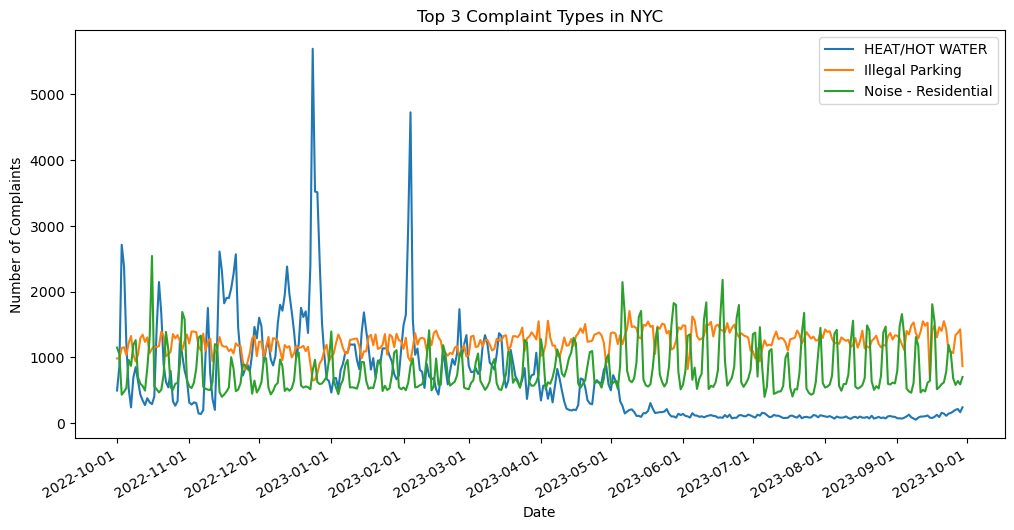

In [59]:
# Call the function to visualize the data
visualize_top_3_complaints()

AttributeError: type object 'datetime.datetime' has no attribute 'timedelta'

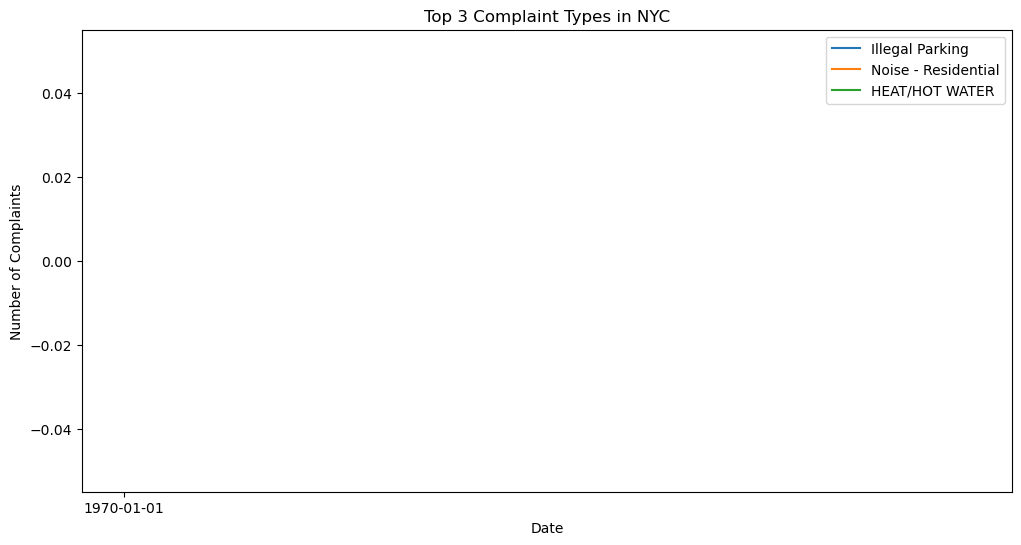

In [60]:
def visualize_top_3_complaints():
    engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")

    # Query to get top 3 complaint types
    top_complaints_query = """
    SELECT complaint_type, COUNT(*) as total_complaints
    FROM complaints
    WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY total_complaints DESC
    LIMIT 3
    """
    top_complaints_df = pd.read_sql(top_complaints_query, engine)

    # Query to get daily complaints for these types
    daily_complaints_query = """
    SELECT date_trunc('day', created_date) as date, complaint_type, COUNT(*) as daily_count
    FROM complaints
    WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
    AND complaint_type IN ('{}')
    GROUP BY date, complaint_type
    ORDER BY date
    """.format("', '".join(top_complaints_df['complaint_type'].tolist()))
    daily_complaints_df = pd.read_sql(daily_complaints_query, engine)

    # Prepare the figure for animation
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Complaints')
    ax.set_title('Top 3 Complaint Types in NYC')

    # Initializing empty lines for each complaint type
    lines = {complaint_type: ax.plot([], [], label=complaint_type)[0] for complaint_type in top_complaints_df['complaint_type']}
    ax.legend()

    # Animation update function
    def update(frame):
        for complaint_type in lines:
            subset = daily_complaints_df[(daily_complaints_df['complaint_type'] == complaint_type) & (daily_complaints_df['date'] <= frame)]
            lines[complaint_type].set_data(subset['date'], subset['daily_count'])
        return list(lines.values())

    # Determine animation frames (dates)
    start_date = daily_complaints_df['date'].min()
    end_date = daily_complaints_df['date'].max()
    total_days = (end_date - start_date).days
    frames = [start_date + datetime.timedelta(days=i) for i in range(total_days + 1)]

    # Create the animation
    ani = FuncAnimation(fig, update, frames=frames, blit=True, interval=100)

    plt.show()

# Call the function
visualize_top_3_complaints()


## Visualization 2: Common Complaints in Zip Code 10027

**Objective:** Visualize the top 10 complaint types in Zip Code 10027 between October 1st, 2018, and September 30th, 2023.

**Implementation:** 
1. We use an SQL query to extract the top 10 complaint types from Zip Code 10027 within the specified timeframe.
2. The retrieved data is then plotted as a bar chart using Matplotlib.
3. The x-axis displays the complaint types, while the y-axis represents the number of complaints.
4. The visualization provides a clear overview of the most common complaints in this specific zip code.
5. To enhance readability, we rotate the x-axis labels.

**Interpretation:** 
This visualization helps us understand the most frequent issues reported in Zip Code 10027 over the specified period. It can be valuable for local authorities and residents in addressing and prioritizing neighborhood concerns.


In [61]:
def visualize_common_complaints_zip_10027():
    engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")

    # SQL query to get top 10 complaints in zip code 10027
    query = """
    SELECT complaint_type, COUNT(*) as complaint_count
    FROM complaints
    WHERE zipcode = '10027' AND created_date BETWEEN '2018-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY complaint_count DESC
    LIMIT 10
    """
    df = pd.read_sql(query, engine)

    # Plotting
    plt.figure(figsize=(10, 6))
    df.plot(kind='bar', x='complaint_type', y='complaint_count', legend=False, ax=plt.gca())
    plt.title('Top 10 Complaints in Zip Code 10027 (2018-2023)')
    plt.xlabel('Complaint Type')
    plt.ylabel('Number of Complaints')
    plt.xticks(rotation=60)  # Rotate labels
    plt.tight_layout()
    plt.show()

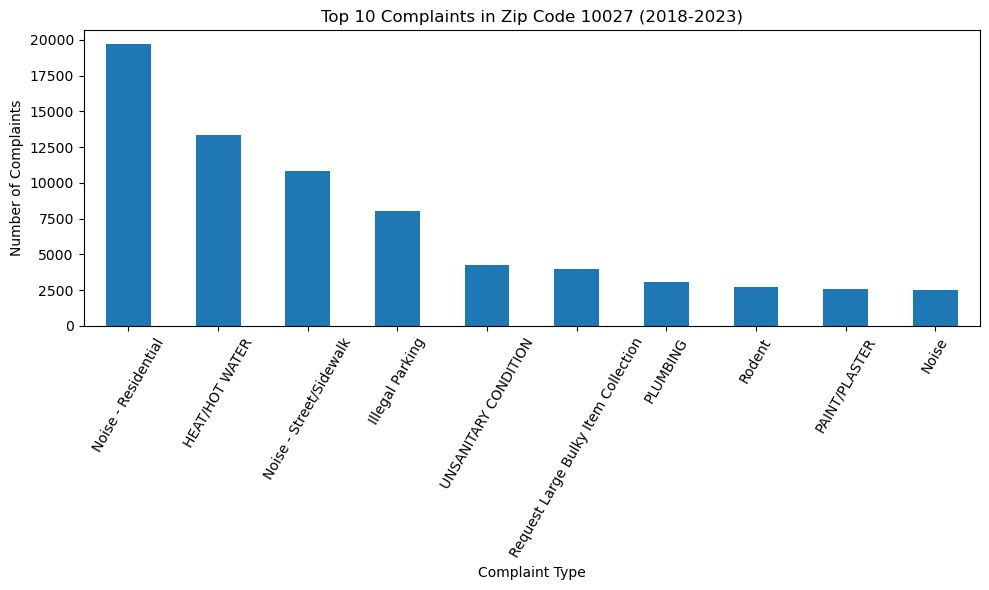

In [62]:
# Call the function to visualize the data
visualize_common_complaints_zip_10027()

## Visualization 3: Correlation Between Rent, Trees, and Complaints

**Objective:** 
The goal is to visualize and explore the correlation between average rent, the number of trees, and the number of complaints by zip code from January 1st, 2015, to September 30th, 2023.

**Implementation Steps:** 
1. **Data Retrieval through SQL Queries:**
   - Utilize SQL queries to extract aggregated data from a PostgreSQL database. This data includes the average rent, total number of trees, and total number of complaints for each zip code, within the specified time frame.
2. **Data Visualization using Matplotlib:**
   - Create two subplots using Matplotlib to plot the retrieved data:
     - **First Subplot:** Visualize the relationship between average rent and the number of trees by zip code through a scatter plot.
     - **Second Subplot:** Show the correlation between average rent and the number of complaints by zip code using a scatter plot.
   - Ensure that both subplots share the same x-axis (average rent) to facilitate direct comparison.
3. **Layout Adjustments:**
   - Adjust the layout for clear visibility and comparison between the two plots.

**Interpretation:** 
The visualizations provide a comparative analysis of how average rent correlates with the number of trees and complaints across different zip codes. By examining these scatter plots, we can identify potential patterns or anomalies, such as whether higher rent areas have more trees or fewer complaints. This analysis helps in understanding urban dynamics and could inform urban planning and resource allocation strategies. 

In [63]:
def visualize_rent_trees_complaints_correlation():
    # Create a connection to the PostgreSQL database
    engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")

    # SQL query to fetch average rent and tree count per zipcode
    tree_query = """
    WITH RentData AS (
        SELECT zipcode, AVG(value) AS avg_rent
        FROM zillows
        WHERE date BETWEEN '2015-01-01' AND '2023-09-30'
        GROUP BY zipcode
    ), 
    TreeData AS (
        SELECT zipcode, COUNT(tree_id) AS tree_count
        FROM trees
        GROUP BY zipcode
    )
    SELECT R.zipcode, R.avg_rent, COALESCE(T.tree_count, 0) AS tree_count
    FROM RentData R
    LEFT JOIN TreeData T ON R.zipcode = T.zipcode;
    """
    # Execute the query and store the result in a DataFrame
    tree_df = pd.read_sql(tree_query, engine)

    # SQL query to fetch average rent and complaint count per zipcode
    complaint_query = """
    WITH RentData AS (
        SELECT zipcode, AVG(value) as avg_rent
        FROM zillows
        WHERE date BETWEEN '2015-01-01' AND '2023-09-30'
        GROUP BY zipcode
    ),
    ComplaintData AS (
        SELECT zipcode, COUNT(unique_key) as complaint_count
        FROM complaints
        WHERE created_date BETWEEN '2015-01-01' AND '2023-09-30'
        GROUP BY zipcode
    )
    SELECT R.zipcode, R.avg_rent, COALESCE(C.complaint_count, 0) as complaint_count
    FROM RentData R
    LEFT JOIN ComplaintData C ON R.zipcode = C.zipcode;
    """
    # Execute the query and store the result in a DataFrame
    complaint_df = pd.read_sql(complaint_query, engine)

    # Create subplots for visualizing the data
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # First subplot: Plotting Rent vs. Number of Trees
    ax1.scatter(tree_df['avg_rent'], tree_df['tree_count'], color='#6fa8dc')
    ax1.set_title('Rent vs. Number of Trees by Zip Code')
    ax1.set_ylabel('Number of Trees')

    # Second subplot: Plotting Rent vs. Number of Complaints
    ax2.scatter(complaint_df['avg_rent'], complaint_df['complaint_count'], color='#bf9000')
    ax2.set_title('Rent vs. Number of Complaints by Zip Code')
    ax2.set_xlabel('Average Rent')
    ax2.set_ylabel('Number of Complaints')

    # Display the plot
    plt.tight_layout()
    plt.show()


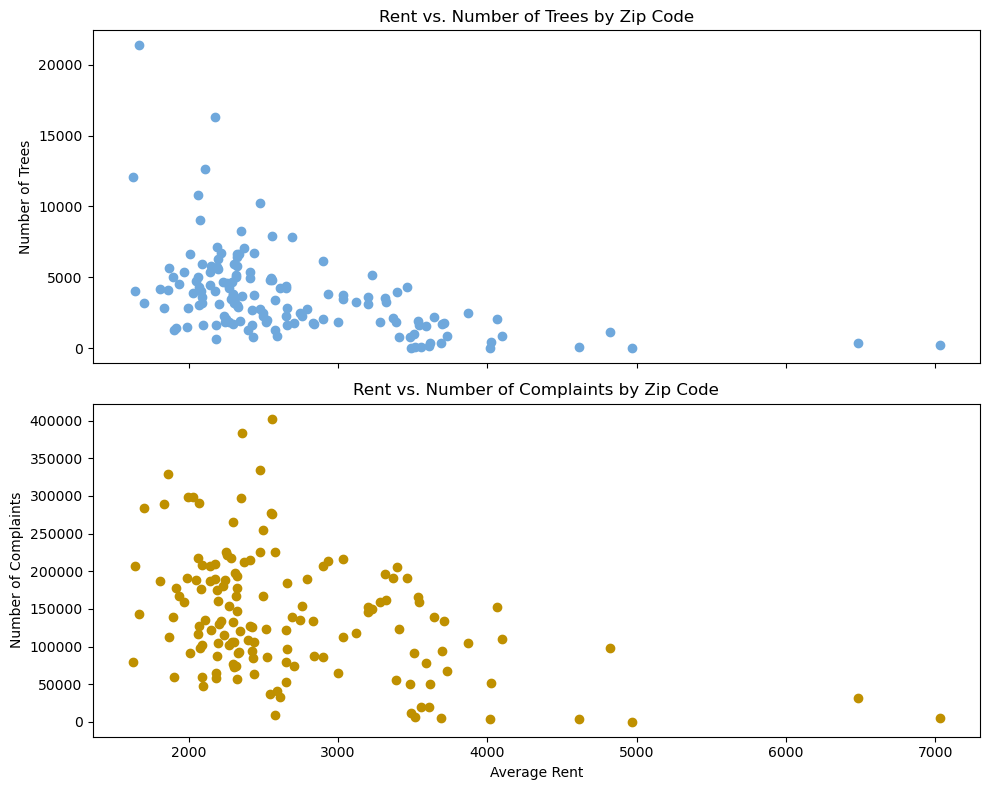

In [64]:
# Call the function to visualize the data
visualize_rent_trees_complaints_correlation()

## Visualization 4: Relationship Between Rent and Complaints

**Objective:** Visualize the relationship between average rent and the number of 311 complaints in different rent ranges for September 2023.

**Implementation:** 
1. **Data Retrieval**: An SQL query retrieves average rent and the number of complaints for each zip code within September 2023.
2. **Data Grouping**: The data is binned into $1000 increments to categorize average rent ranges.
3. **Boxplot Creation**: A boxplot displays the distribution of complaint counts within each rent range.
4. **Axes Representation**: The x-axis represents binned average rent, and the y-axis shows the number of complaints.
5. **Purpose**: This visualization assists in determining if higher rent areas tend to have fewer 311 complaints.

**Interpretation:** 
The boxplot provides insights into the relationship between average rent and the number of complaints in September 2023. By categorizing average rent into bins and visualizing the spread of complaints within each range, we can identify trends or patterns in how rent levels may correlate with the frequency of complaints.

In [65]:
def visualize_rent_vs_complaints():
    # Establish a connection to the PostgreSQL database
    engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")

    # Define an SQL query to fetch average rent and complaint counts per zipcode
    query = """
    WITH RentData AS (
        SELECT zipcode, AVG(value) as avg_rent
        FROM zillows
        WHERE date >= '2023-09-01' AND date < '2023-10-01'
        GROUP BY zipcode
    ),
    ComplaintData AS (
        SELECT zipcode, COUNT(unique_key) as complaint_count
        FROM complaints
        WHERE created_date >= '2022-10-01' AND created_date < '2023-10-01'
        GROUP BY zipcode
    )
    SELECT RD.zipcode, RD.avg_rent, CD.complaint_count
    FROM RentData RD
    LEFT JOIN ComplaintData CD ON RD.zipcode = CD.zipcode;
    """

    # Execute the query and store the result in a DataFrame
    df = pd.read_sql(query, engine)

    # Bin the average rent into $1000 intervals for grouping
    df['rent_bin'] = pd.cut(df['avg_rent'], bins=range(0, int(df['avg_rent'].max()) + 1000, 1000), right=False)

    # Create a boxplot to visualize the data
    plt.figure(figsize=(12, 6))
    df.boxplot(column='complaint_count', by='rent_bin', grid=False)

    # Set titles and labels for the plot
    plt.title('Number of 311 Complaints vs. Average Rent')
    plt.suptitle('')
    plt.xlabel('Average Rent ($1000 bins)')
    plt.ylabel('Number of 311 Complaints')
    plt.xticks(rotation=45)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


<Figure size 1200x600 with 0 Axes>

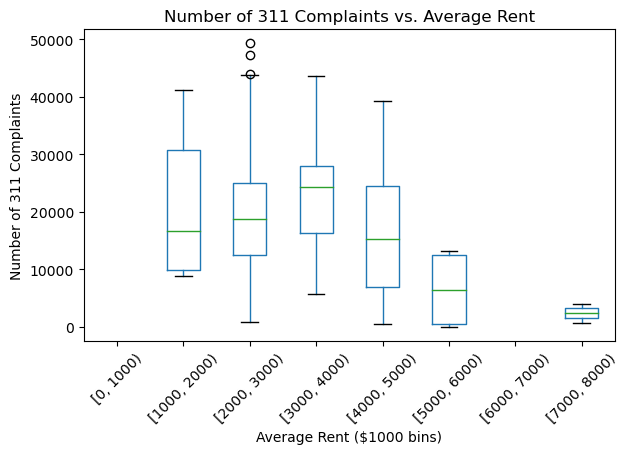

In [66]:
# Call the function to visualize the data
visualize_rent_vs_complaints()

## Visualization 5: Recent 311 Incidents Near a Specific Location

**Objective:** Generate a geospatial visualization of 311 incident locations reported between January 1st, 2023, and September 30th, 2023, within a 1-kilometer radius of a specified coordinate point.

**Implementation:** 
1. An SQL query fetches 311 incident data within the defined period (January to September 2023) and within a 1-kilometer radius of a predetermined set of coordinates.
2. The data is transformed into a GeoDataFrame, enabling geospatial plotting.
3. The resulting map displays the locations of 311 incidents with blue markers.
4. The central point for this analysis is set at the coordinates (latitude: 40.80737875669467, longitude: -73.96253174434912).

**Interpretation:** 
This visualization offers a geospatial understanding of 311 incidents reported near a specific location. By mapping the incident locations, it becomes possible to visually examine the concentration and distribution of these incidents in proximity to the chosen point of interest. Such insights are valuable for identifying local patterns and potential areas of concern within the neighborhood.


In [67]:
def visualize_311_incidents():
    # Connect to the PostgreSQL database
    engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")

    # Central point information
    longitude = -73.96253174434912
    latitude = 40.80737875669467
    radius = 1000  # in meters

    # Fetch data from the database for 311 complaints within the specified radius and time range
    query = """
    SELECT unique_key, ST_X(geometry) as longitude, ST_Y(geometry) as latitude
    FROM complaints
    WHERE created_date BETWEEN '2023-01-01' AND '2023-09-30'
    AND ST_DWithin(geometry, ST_SetSRID(ST_MakePoint(%s, %s), 4326)::geography, %s)
    """
    df = pd.read_sql(query, engine, params=(longitude, latitude, radius))

    # Create a GeoDataFrame from the DataFrame
    gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df.longitude, df.latitude)])

    # Create a geospatial plot
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, color='blue', markersize=5)

    plt.title('311 Incidents Reported from Jan 1, 2023, to Sep 30, 2023, within 1 km Radius')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()


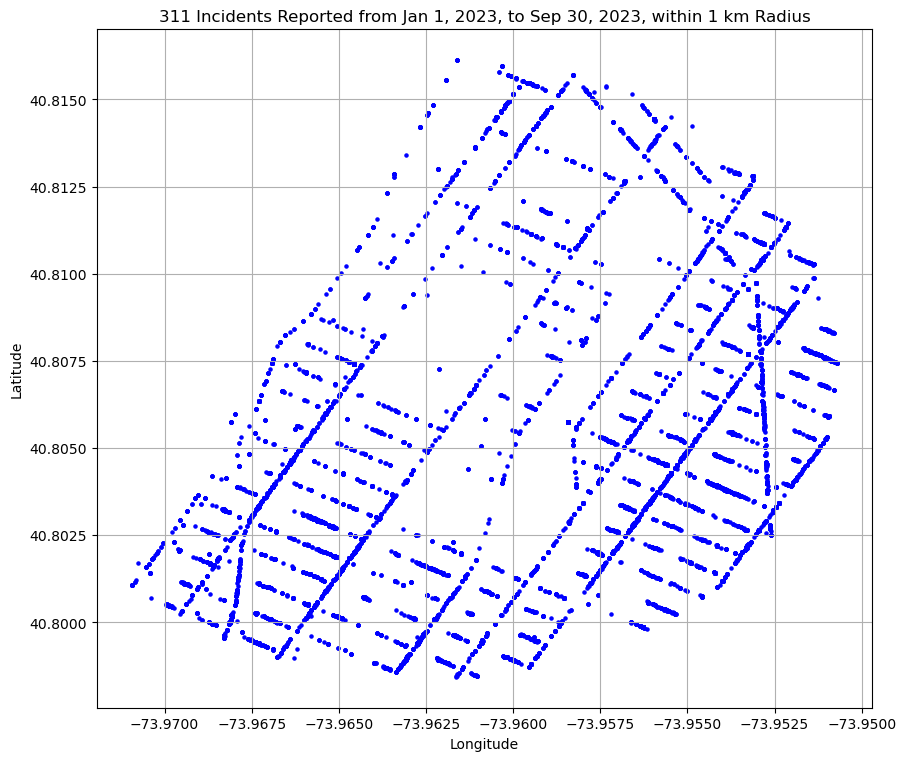

In [68]:
# Call the function to visualize the data
visualize_311_incidents()

## Visualization 6: Trees and New Tree Requests in NYC

**Objective:** Create a geospatial plot that visualizes two sets of data - the coordinates of trees in NYC and the coordinates of "New Tree Request" 311 complaints made between October 1st, 2018, and September 30th, 2023.

**Implementation:** 
1. Two separate SQL queries are used to retrieve data for trees and "New Tree Request" complaints from the database.
2. The data is converted into GeoDataFrames to enable geospatial plotting.
3. The GeoDataFrames are overlaid on a single plot, with trees represented as green markers and new tree requests as blue markers.
4. The resulting plot displays the locations of both trees and new tree requests, allowing for a visual comparison.

**Interpretation:** 
This visualization allows us to explore the relationship between existing trees and the demand for new trees in NYC. By plotting both datasets on a map, we can visually assess areas with a high concentration of existing trees and areas with a significant number of new tree requests. This information can be valuable for urban planning and tree planting initiatives to identify areas where tree planting efforts may be needed.


In [69]:
def visualize_trees_and_new_requests():
    # Connect to the PostgreSQL database
    engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")

    # SQL query for retrieving tree data
    trees_query = "SELECT tree_id, ST_X(geometry) as longitude, ST_Y(geometry) as latitude FROM trees"
    trees_df = pd.read_sql(trees_query, engine)

    # SQL query for retrieving new tree requests
    requests_query = """
    SELECT unique_key, ST_X(geometry) as longitude, ST_Y(geometry) as latitude
    FROM complaints
    WHERE complaint_type = 'New Tree Request' AND created_date BETWEEN '2018-10-01' AND '2023-09-30'
    """
    requests_df = pd.read_sql(requests_query, engine)

    # Convert the dataframes to GeoDataFrames for spatial analysis
    trees_gdf = gpd.GeoDataFrame(trees_df, geometry=gpd.points_from_xy(trees_df.longitude, trees_df.latitude))
    requests_gdf = gpd.GeoDataFrame(requests_df, geometry=gpd.points_from_xy(requests_df.longitude, requests_df.latitude))

    # Create a plot to visualize the data
    fig, ax = plt.subplots(figsize=(10, 10))
    trees_gdf.plot(ax=ax, marker='o', color='green', markersize=5, label='Trees')
    requests_gdf.plot(ax=ax, marker='x', color='blue', markersize=5, label='New Tree Requests')
    plt.title('Trees and New Tree Requests in NYC')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()


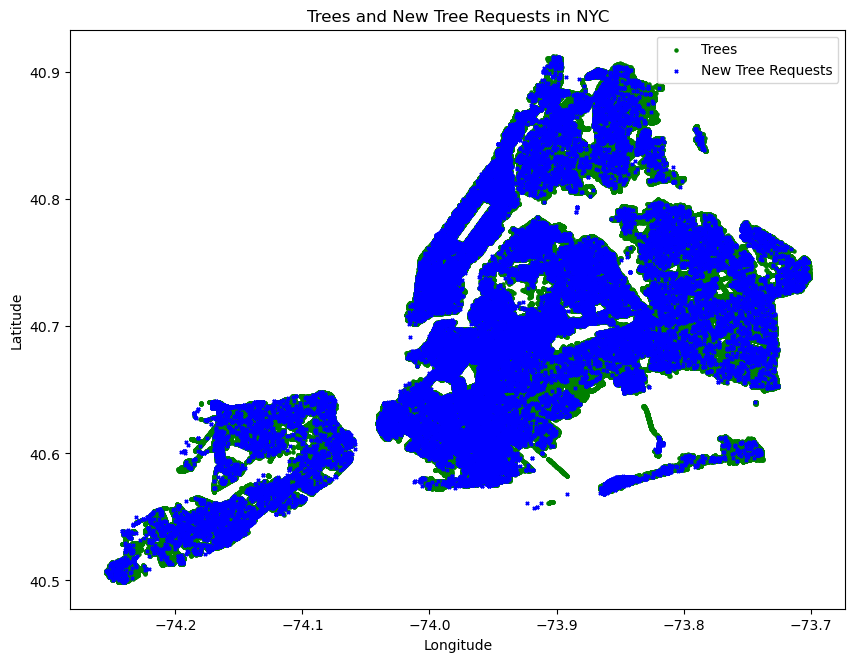

In [70]:
# Call the function to visualize the data
visualize_trees_and_new_requests()